In [1]:
import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

raw = pd.read_csv('Scorecard_Final.csv', low_memory=False)
#source https://www.kaggle.com/kaggle/college-scorecard/home
#each row in this dataset is a branch of a higher education institution. The data comes from the US Dept of Education Scorecard 
#and has been filtered down such that my machine can import it

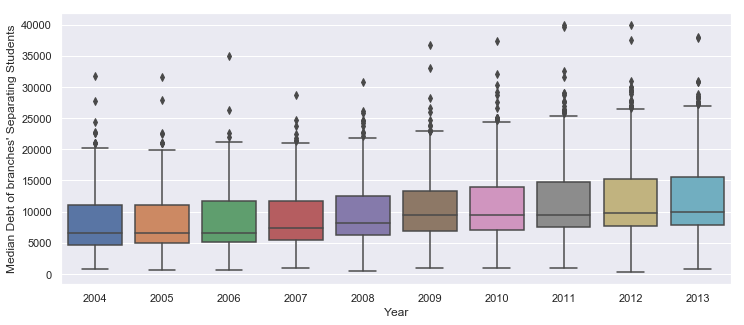

In [2]:
#To analyze debt, I want to create a df with only the rows that have values for the 
#median debt upon the start of repayment
debt = raw[(np.isnan(raw.DEBT_MDN) == False) & (np.isnan(raw.DEBT_N) == False)]

#range of debt values by year
sns.set(style="darkgrid")
plt.figure(figsize=(12,5))
ax = sns.boxplot(y='DEBT_MDN', x='Year', data=debt)
ax.set(ylabel='Median Debt of branches\' Separating Students')
plt.show()

# As we can see above, debt values have been increasing steadily for years. 

In [6]:
#Early data review determined that the count of students (DEBT_N) for the debt measurements was innaccurate. Many
# Schools with numerous branches seem to report the same number for all branches, suggesting they might have mistakenly
#listed the institution total for EVERY branch. Here I divide the count by the branch count to estimate a true student count
#for the branch.
debt = debt.assign(studNum = debt['DEBT_N'] / debt['NUMBRANCH'])


#This is an estimate of the total debt issued to students on behalf of each branch
debt = debt.assign(totalDebtForBranch = debt['DEBT_MDN'] * debt['studNum'])

#Next I'll use the student counts of sex demographics to 
#create the % of the students who fall into each bucket.

#Data note: this could have been accomplished in an simpler way with student counts instead of using percentages. however,
#the parts didn't sum to the whole (male_debt_n + female_debt_n != debt_n), so percents are being calculated instead.

debt['malePCT'] = debt['MALE_DEBT_N'] / (debt['MALE_DEBT_N'] + debt['FEMALE_DEBT_N'])
debt['femalePCT'] = 1 - debt['malePCT']

#Isolate the columns I need to improve processing speed
debtAnalysis= debt[['UNITID', 'studNum', 'totalDebtForBranch', 'malePCT', 'femalePCT','Year']]

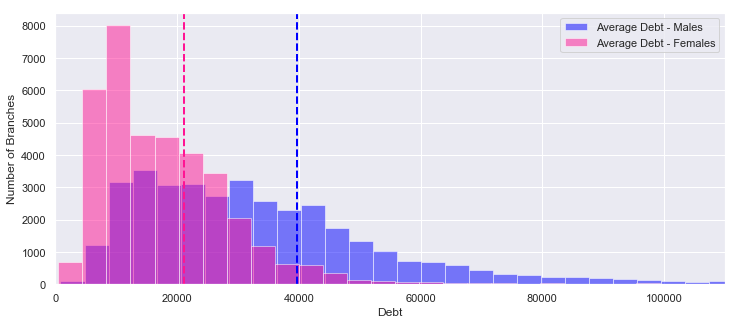

Ttest_indResult(statistic=62.026536878363274, pvalue=0.0)


In [7]:
#BY dividing the total branch debt by the estimated number of students in each group, we can get an 
#average debt for each student by branch.
debtAnalysis = debtAnalysis.assign(maleAvgDebt = debtAnalysis['totalDebtForBranch'] / (debt['studNum'] * debt['malePCT']))
debtAnalysis = debtAnalysis.assign(femaleAvgDebt = debtAnalysis['totalDebtForBranch'] / (debt['studNum'] * debt['femalePCT']))


#Remove Nan's
genderAnalysisInf = debtAnalysis[(np.isnan(debtAnalysis.maleAvgDebt) == False) & (np.isnan(debtAnalysis.femaleAvgDebt) == False)]
#Remove Infinite values created by the above multiplication being done on blank cells
genderAnalysis = genderAnalysisInf.dropna(how='any')

plt.figure(figsize=(12,5))
plt.hist(genderAnalysis['maleAvgDebt'], bins=400, label='Average Debt - Males', alpha=.5, color='#0000FF')
plt.axvline(genderAnalysis.maleAvgDebt.mean(), color='#0000FF', linestyle='dashed', linewidth=2)
plt.hist(genderAnalysis['femaleAvgDebt'], bins=550, label='Average Debt - Females', alpha=.5, color='#FF1493')
plt.axvline(genderAnalysis.femaleAvgDebt.mean(), color='#FF1493', linestyle='dashed', linewidth=2)
plt.xlim(0,110000)
plt.ylabel('Number of Branches')
plt.xlabel('Debt')
plt.legend()
plt.show()

print(ttest_ind(genderAnalysis.maleAvgDebt, genderAnalysis.femaleAvgDebt, equal_var=False))

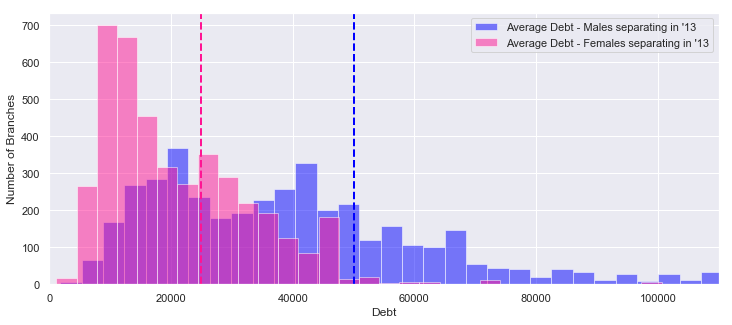

Ttest_indResult(statistic=24.887754563349404, pvalue=3.5997605251986845e-131)


In [13]:
#Is this also true of the most recent year only?

debt13 = debtAnalysis[debtAnalysis.Year == 2013]

#Remove Nan's
genderAnalysisInf13 = debt13[(np.isnan(debt13.maleAvgDebt) == False) & (np.isnan(debt13.femaleAvgDebt) == False)]
#Remove Infinite values created by the above multiplication being done on blank cells
genderAnalysis13 = genderAnalysisInf13.dropna(how='any')

plt.figure(figsize=(12,5))
plt.hist(genderAnalysis13['maleAvgDebt'], bins = 450, label='Average Debt - Males separating in \'13', alpha=.5, color='#0000FF')
plt.axvline(genderAnalysis13.maleAvgDebt.mean(), color='#0000FF', linestyle='dashed', linewidth=2)
plt.hist(genderAnalysis13['femaleAvgDebt'], bins = 200, label='Average Debt - Females separating in \'13', alpha=.5, color='#FF1493')
plt.axvline(genderAnalysis13.femaleAvgDebt.mean(), color='#FF1493', linestyle='dashed', linewidth=2)
plt.xlim(0,110000)
plt.ylabel('Number of Branches')
plt.xlabel('Debt')
plt.legend()
plt.show()

print(ttest_ind(genderAnalysis13.maleAvgDebt, genderAnalysis13.femaleAvgDebt, equal_var=False))

# Problem
The above heavily implies that men graduate with more debt than women. However, this mean is a "mean of medians". In other words, each row in this dataset is a branch reporting the median debt of its graduates/withdrawing students, and I'm averaging those medians. Theoretically, there's risk that we've fallen on the wrong side of Simpson's Paradox here. Ideally we could remove that layer and sample individuals directly.
# Question: Do Men and Women Separate from higher education with the same amount of debt?
Hypothesis based on the above: Men separate from higher education with more debt than women.  
Null Hypothesis: There is no difference in the debt for men and women.

# Rollout plan


We'll design a survey of N men and N women who have separated from school in the past 6 months. We will reach them through the school they separated from, using that as a privacy filter. Cooperating schools, in exchange for credit or perhaps compensation, will forward our survey to selections of their student base, who can complete it in browser instantly. 

**So how many respondents do we need?**

In [24]:
###CALCULATE THAT HERE



# Survey and Success Criteria
The questions on the survey will include the following:
* Date of separation from school
* Total Student Loan amount upon separation
* Current Annualized Earnings
* Sex
* The remaining demographic questions will be optional to encourage a higher sample:
* Race
* School Name
* Program of Study/Degree
* Graduate/Drop out


**The key item of study will be the Total Studnet Loan amount upon separation; we want to know if there's a meaningful difference between men and women's balances.** If the difference is found to be significant with 95% confidence, we will reject the null hypothesis.

The other data will be collected to add perspective to the outcome of this question and to verify no bias was collected.


# Bias

These steps will be taken to minimize bias:

* The survey will not be titled anything specific to Debt or Sex, so that we don't get a better open rate from different groups
* The survey needs to reach the following groups in equal proportion to their estimated existence in the broader population:
  - Vocational Schools, Associate programs, Bachelor programs, Graduate Programs. 
  - Graduated Students vs. Withdrawn Students
  - Programs of study, broadly classified (i.e. business vs. engineering vs...etc)
  - Race
  - Region  
  
The first bullet can be accomplished by our choice of which schools to approach for cooperation. The rest can be accomplished by passing those schools instructions, as they maintain those demographics and can distribute the surveys appropriately to achieve the sample we want. 

Even if the above is successful, this study will still be biased in these ways:
* People with stronger feelings about their debt, most likely those with more of it, may be more likely to complete the survey once they see what it's about
* This survey will primarily reach people who have valid email addresses on file with the school they attended